# Задача поиска тренда в финансовых данных  (10 pts)

В работе [l-1 trend filtering](https://web.stanford.edu/~boyd/papers/l1_trend_filter.html) авторы предложили подход к выявлению тренда в финансовых временных рядах с помощью выпуклой оптимизации. В частности, вместо построения стохастической модели временного ряда, они предложили отталкиваться от задачи - построить кусочно-линейную линию тренда, наилучшим образом аппроксимирующую данный временной ряд.

Это привело к задачи оптимизации следующего вида:

**Trend filtering problem**

$$
\min_{x \in \mathbb{R}^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1
$$

где $y \in \mathbb{R}^T$ - временной ряд фактических цен акций (с момента времени $t = 1$ до момента времени $T$), матрица $D \in \mathbb{R}^{(T-2) \times T}$ является трехдиагональной: $[Dx]_i = x_i - 2 x_{i+1} + x_{i+2}, 1 \leq i \leq T-2$.

Первый член в целевой функции отвечает за близость решения к фактическим данным, а второй накладывает на решение требование быть кусочно-линейной функцией с минимальным числом точек негладкости. 


1. Скачайте тестовые данные: данные о цене закрытия акций российских финансовых компаний. Это данные, которые соответствуют вектору $y$. 
2. (4 pts.) С помощью функции Хьюбера запишите сглаженную версию задачи Trend Filter и найдите ее решение используя ускоренный метод градиентного спуска. Вспомните занятие про сопряжённые функции и пример оттуда. Как на скорость и точность решения влияет параметр сглаживания? Прокомментируйте результат. 
3. (4 pts.) Запишите формулы необходимые для метода ADMM для исходной решения задачи Trend Filter, реализуйте их и найдите численное решение задачи методов ADMM. 
4. (2 pts) Сравните скорость сходимости и точность метода ADMM и быстрого градиентного спуска, применённого к сглаженной версии задачи. Какой метод оказался предпочтительнее и почему?

In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import scipy as sp
import cvxopt as cvxopt
import numba
from tqdm import tqdm
import typing as tp
import matplotlib.pyplot as plt

plt.rcParams.update({'text.usetex' : True, 'font.size' : 14})

# load data: IMOEX close prices
moex_df = pd.read_csv(
    'IMOEX_200101_241210.csv', 
    dtype={'TICKER' : str, 'PER' : str, 'DATE' : str, 'TIME' : np.float64, 'CLOSE' : np.float64}
)
y = moex_df['CLOSE'].to_numpy()
T = len(y)

# form second finite difference matrix - it's tridiagonal matrix, so we will use sparse form
e = np.ones((1, T))
D = sp.sparse.diags((e, -2*e, e), range(3), (T - 2, T), format='dia')

Для начала решим исходную и сглаженную задачу с использованием библиотеки `cvxpy` с автоматически подобранным солвером `OSQP`, основанным на ADMM с оптимизациями для разреженных матриц. Будем использовать полученное решения для верификации результатов собственных методов. Можно видеть, что скорость сходимости для сглаженной задачи заметно выше (объяснение данного эффекта будет обсуждаться ниже).

In [2]:
# L1 regularization
x_l1_cvxpy = cp.Variable(shape=T)
lambd_l1 = 1e5
obj_l1 = cp.Minimize(0.5 * cp.sum_squares(y - x_l1_cvxpy) + lambd_l1 * cp.norm(D @ x_l1_cvxpy, 1))
problem_l1 = cp.Problem(obj_l1)

problem_l1.solve(verbose=True)
if problem_l1.status != cp.OPTIMAL:
    raise Exception("No convergence")

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Jan 29 12:20:19 AM: Your problem has 1234 variables, 0 constraints, and 0 parameters.
(CVXPY) Jan 29 12:20:19 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 29 12:20:19 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 29 12:20:19 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 29 12:20:19 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 29 12:20:19 AM: Compiling problem (target solver=OSQP).
(C

In [3]:
# smoothed huber regularization
x_huber_cvxpy = cp.Variable(shape=T)
lambd_huber = 1e5
eps_huber = 1e-5
obj_huber = cp.Minimize(0.5 * cp.sum_squares(y - x_huber_cvxpy) + lambd_huber * (0.5/eps_huber) * cp.sum(cp.huber(D @ x_huber_cvxpy, eps_huber)))
problem_huber = cp.Problem(obj_huber)

problem_huber.solve(verbose=True)
if problem_huber.status != cp.OPTIMAL:
    raise Exception("No convergence")

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Jan 29 12:20:19 AM: Your problem has 1234 variables, 0 constraints, and 0 parameters.
(CVXPY) Jan 29 12:20:19 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 29 12:20:19 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 29 12:20:19 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 29 12:20:19 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 29 12:20:19 AM: Compiling problem (target solver=OSQP).
(C

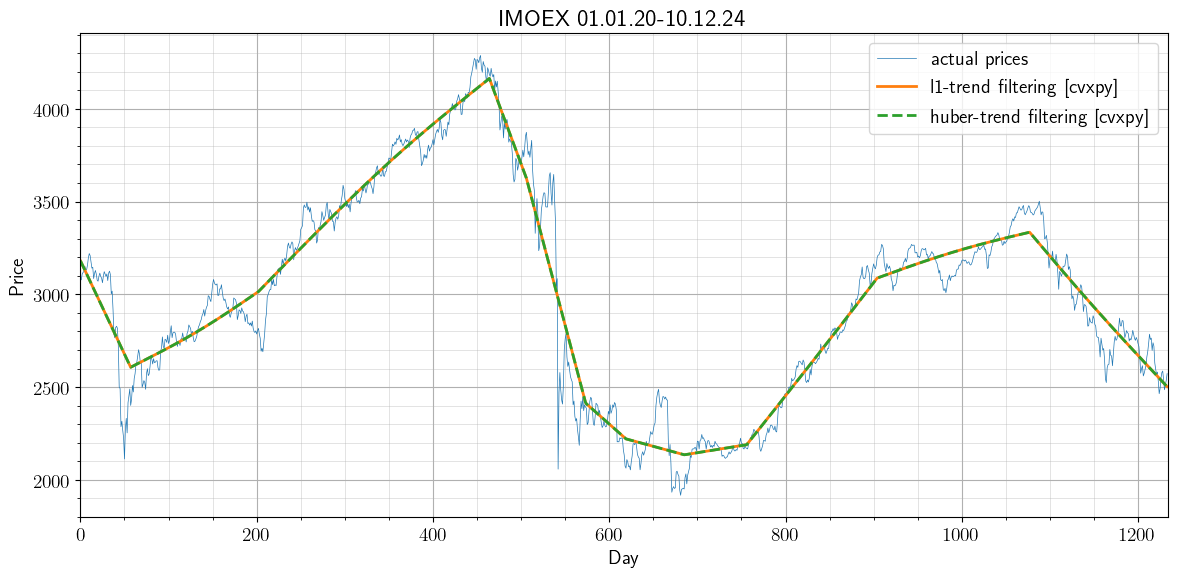

In [4]:
plt.figure(figsize=(12, 6))
plt.title('IMOEX 01.01.20-10.12.24')
plt.plot(y, lw=0.5, label='actual prices')
plt.plot(x_l1_cvxpy.value, lw=2, ls='-', label='l1-trend filtering [cvxpy]')
plt.plot(x_huber_cvxpy.value, lw=2, ls='--', label='huber-trend filtering [cvxpy]')
plt.minorticks_on()
plt.xlim([0, T])
plt.grid(True, 'major'); plt.grid(True, 'minor', lw=0.5, alpha=0.5)
plt.xlabel('Day'); plt.ylabel('Price')
plt.legend()
plt.tight_layout()

In [5]:
def plot_grad_norm_and_loss(
        grad_norm_loss_dict: dict[str, tuple[tp.Optional[np.ndarray], np.ndarray]],
        plot_grad_norm: bool = False,
        title: str = "",
        loglog_grad_norm: bool = False,
        loglog_loss: bool = True,
    ) -> None:
    
    if plot_grad_norm:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        ax = [None, ax]
        
    fig.suptitle(title)
    
    for k, (name, (grad_norm, loss)) in enumerate(grad_norm_loss_dict.items()):
        name = name + f" [it: {len(loss):g}]"
        if plot_grad_norm:
            if loglog_grad_norm:
                ax[0].loglog(grad_norm, label=name, color=f'C{k}')
                ax[0].scatter(len(grad_norm), grad_norm[-1], color=f'C{k}', edgecolor='black', marker='*', s=100, zorder=10)
            else:
                ax[0].semilogy(grad_norm, label=name, color=f'C{k}')
                ax[0].scatter(len(grad_norm), grad_norm[-1], color=f'C{k}', edgecolor='black', marker='*', s=100, zorder=10)
        
        if loglog_loss:
            ax[1].loglog(loss, label=name, color=f'C{k}')
            ax[1].scatter(len(loss), loss[-1], color=f'C{k}', edgecolor='black', marker='*', s=100, zorder=10)
        else:
            ax[1].semilogy(loss, label=name, color=f'C{k}')
            ax[1].scatter(len(loss), loss[-1], color=f'C{k}', edgecolor='black', marker='*', s=100, zorder=10)
        
    if plot_grad_norm:
        ax[0].legend()
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('Gradient norm')
        ax[0].minorticks_on()
        ax[0].grid(True, which='major'); ax[0].grid(True, which='minor', lw=0.3, alpha=0.5)
    
    ax[1].legend()
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Loss')
    ax[1].minorticks_on()
    ax[1].grid(True, which='major'); plt.grid(True, which='minor', lw=0.3, alpha=0.5)

    fig.tight_layout()
    
def plot_price_and_trends(
    price: np.ndarray,
    trends_dict: dict[str, tuple[np.ndarray]],
    title: str = 'IMOEX 01.01.20-10.12.24'
):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.plot(price, lw=0.5, label='actual prices')
    for name, trend in trends_dict.items():
        plt.plot(trend, lw=2, ls='--', label=name)
    plt.minorticks_on()
    plt.xlim([0, T])
    plt.grid(True, 'major'); plt.grid(True, 'minor', lw=0.5, alpha=0.5)
    plt.xlabel('Day'); plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()

In [6]:
@numba.njit
def huber(x: np.ndarray, eps: float = eps_huber) -> np.ndarray:
    abs_x = np.abs(x)
    return np.where(abs_x <= eps, 0.5 * x**2 / eps, abs_x - 0.5 * eps)

@numba.njit
def huber_grad(x: np.ndarray, eps: float = eps_huber) -> np.ndarray:
    abs_x = np.abs(x)
    return np.where(abs_x <= eps, x / eps, np.sign(x))

def huber_trend_filtering_grad(
        x: np.ndarray, 
        y: np.ndarray = y, 
        D: sp.sparse._dia.dia_matrix = D, 
        lambd: float = lambd_huber, 
        eps: float = eps_huber
    ) -> np.ndarray:
    """Compute the gradient of the Huber trend filtering loss."""
    return (x - y) + lambd * D.T @ huber_grad(D @ x, eps)

def huber_trend_filtering_loss(
        x: np.ndarray, 
        y: np.ndarray = y, 
        D: sp.sparse._dia.dia_matrix = D,
        lambd: float = lambd_huber, 
        eps: float = eps_huber
    ) -> float:
    """Compute the Huber trend filtering loss."""
    return 0.5 * np.sum((x - y)**2) + lambd * np.sum(huber(D @ x, eps))

### Accelerated GD (AGD) cо сгаживанием исходной задачи

Исходная задача из-за l1 регуляризатора на вторую конечную разность $x$ делает задачу негладкой (l1 норма не дифференцируема в нуле). 

Вспомним следующую теорему:

**Теорема**

Пусть $f$ &mdash; сильно выпуклая функция с константой $m > 0$ и $f^*(y) = \sup\limits_x (y^\top x - f(x))$ &mdash; сопряженная к ней функция. Тогда:

1. $f^*$ определена и *дифференцируема* и $\nabla f^*(y) = \argmax\limits_x(y^\top x - f(x))$;
2. $\nabla f^*(y)$ &mdash; Липшицев с константой $1/m$.

Рассмотрим сглаживание через инфимальную свертку с l2-нормой для функции $g(x) = \Vert x \Vert_1$. Запишем определение:

$M_{\tau g}(x) = \left(g \square \dfrac{\tau}{2}\Vert \cdot \Vert_2\right)(x) = \inf\limits_u \left[ g(u) + \dfrac{\tau}{2}\Vert u - x \Vert_2 \right]$.

Из свойств инфимальной светрки следует, что введенная функция $M_{\tau g}$ &mdash; выпуклая (выпуклы сворачиваемые функции). Рассмотрим сопряжение данной функции, $M_{\tau g}^*$. В задании №3 было доказано, что сопряженная функция к инфимальной свертке функций &mdash; это сумма сопрягаемых функций. Таким образомб учитывая, что l2 норма самосопряженная, получаем:

$M_{\tau g}^*(x) = g^*(x) + \dfrac{\tau}{2} \Vert x \Vert_2$ &mdash; сильно выпуклая.

Теперь возьмем сопряжение к $M_{\tau g}^*$:

$M_{\tau g}^{**}(x) = \left(g^*(x) + \dfrac{\tau}{2} \Vert x \Vert_2\right)^* = M_{\tau g}(x)$ &mdash; сопряженная к сильно выпуклой функции, а по приведенной теореме это означает, что $M_{\tau g}(x)$ &mdash; дифференцируемая функция.

Для случая $g(x) = \Vert x \Vert_1$ фукнция $M_{\tau g}(x)$ имеет явный вид &mdash; это функция Хьюьбера (доказывалось на лекции):

$\begin{aligned}
M_{\tau g}(x) = \begin{cases}
\dfrac{x^2}{2\tau}, & |x| \leqslant \tau \\
|x| - \dfrac{\tau}{2}, & |x| > \tau
\end{cases}
\end{aligned}$

Также можем видеть, что оптимальное значение функции не меняется и остается равным 0 (вообще говоря, это общий результат для рассмотренного типа сглаживания функций).

В итоге мы получили гладкуб версию исходной задачи с функцией Хьюбера вместо l1-нормы, что дает улучшенную скорость сходимости градиентных методов. 

Будем решать следующую задачу:

$
\min_{x \in \mathbb{R}^T} \frac{1}{2}\|y - x\|_2^2 + \lambda M_{\tau \Vert \cdot \Vert_1}(Dx)
$

Параметр $\tau$ регулирует баланс между точностью решения и его скоростью. Большое значение константы Липшица $L=1/\tau$ гарантирует более высокую точность аппроксимации решения, но снижает скорость решения из-за уменьшения эффекта сглаживания. Малое же значение $L=1/\tau$ дает более высокую скорость сходимости, однако точность решения падает из-за все менее точной аппроксимации исходной несглаженной функции.

В экспериментах коэффициент $\tau$ подбирался экспериментально, в первую очередь исходя из близости к решению исходной задачи.
 

In [7]:
def accelerated_gd(
    grad: tp.Callable[[np.ndarray], np.ndarray],
    loss: tp.Callable[[np.ndarray], float],
    x_0: np.ndarray,
    lr: float,
    restart: bool = False,
    max_iter: int = 1000,
    lr_decay = 0.9999,
    tol: float = 1e-6,
) -> tp.Tuple[np.ndarray, tp.List[float], tp.List[float]]:
    loss_log = []
    grad_log = []
    
    x = x_0.copy()
    y = x_0.copy()
    k = 1

    for it in tqdm(range(max_iter), desc="AGD Iterations"):
        g = grad(y)
        x_next = y - lr * g
        
        if restart and loss(x) < loss(x_next):
            x_next = x - lr * grad(x)
            y = x_next.copy()
            k = 1
        else:
            y = x_next + k / (k + 3) * (x_next - x)
        
        x = x_next.copy()
        k += 1
        lr *= lr_decay

        loss_value = loss(x)
        grad_norm = np.linalg.norm(g)
        loss_log.append(loss_value)
        grad_log.append(grad_norm)

        if grad_norm < tol:
            print(f"Converged in {it + 1} iterations.")
            break
    
    return x, loss_log, grad_log


In [8]:
lambd = lambd_huber   # Regularization parameter
epsilon = eps_huber   # Smoothing parameter (for Huber)

x_agd, loss_log_agd, grad_log_agd = accelerated_gd(
    grad=huber_trend_filtering_grad,
    loss=huber_trend_filtering_loss,
    x_0=y,
    lr=1e-6,
    lr_decay=.9999,
    max_iter=100000,
    restart=False
)

AGD Iterations: 100%|██████████| 100000/100000 [00:20<00:00, 4809.70it/s]


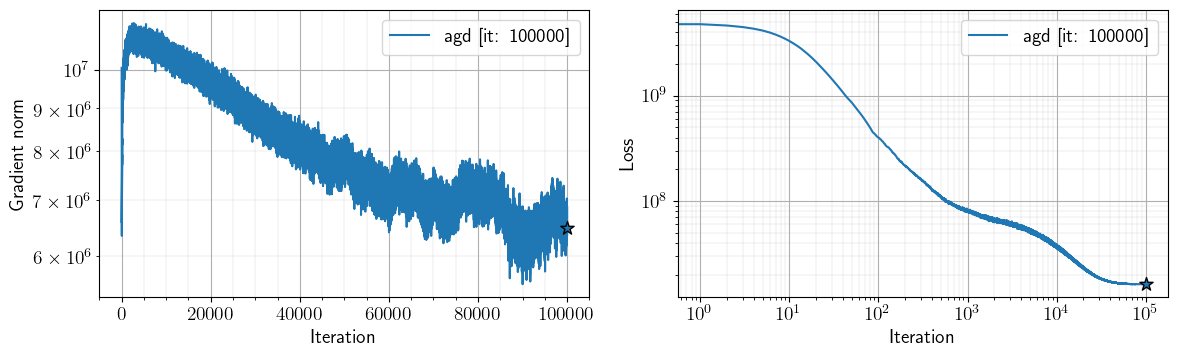

In [9]:
plot_grad_norm_and_loss(
    grad_norm_loss_dict={'agd' : (grad_log_agd, loss_log_agd)},
    plot_grad_norm=True
)

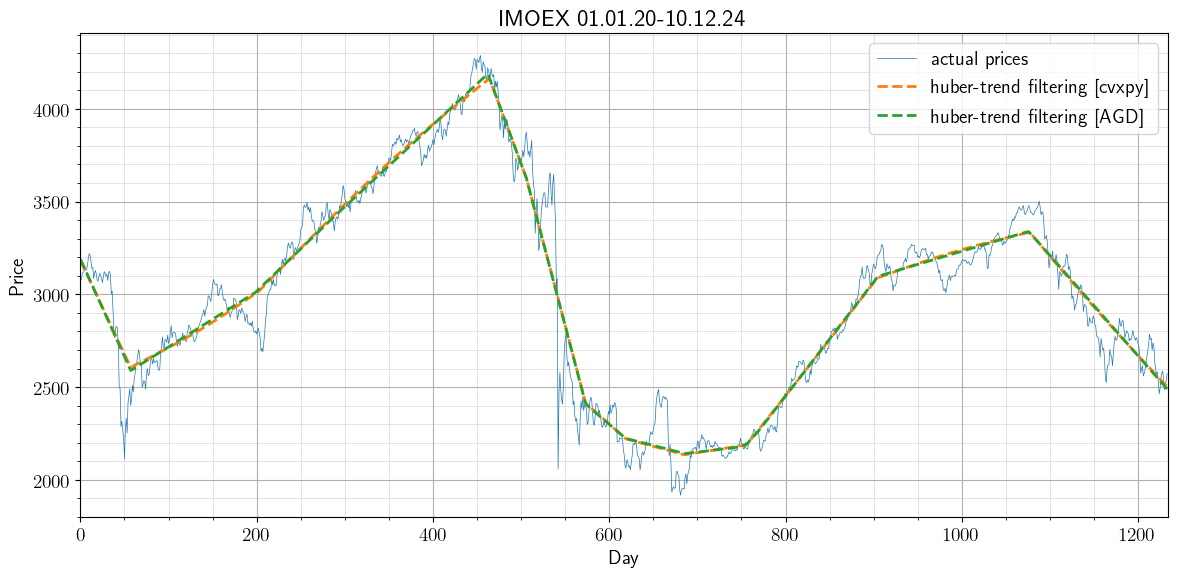

In [10]:
plot_price_and_trends(
    price=y,
    trends_dict={
        'huber-trend filtering [cvxpy]' : x_huber_cvxpy.value,
        'huber-trend filtering [AGD]' : x_agd
    }
)

### ADMM

Для использования ADMM введем переменную $u=Dx \in \mathbb{R}^{T-2}$. Задача переписывается в виде:

$\begin{aligned}
\min\limits_{x,u} \dfrac{1}{2} \Vert y - x \Vert_2^2 + \lambda \Vert u \Vert_1,\quad \text{s.t. } Dx = u 
\end{aligned}$

Модифицированная функция Лагранжа имеет вид:

$\begin{aligned}
L_\rho(x, u, \mu) = \dfrac{1}{2} \Vert y - x \Vert_2^2 + \lambda \Vert u \Vert_1 + \mu^\top (Dx - u) + \dfrac{\rho}{2} \Vert Dx - u\Vert^2_2,\quad \rho > 0
\end{aligned}$

Шаг оптимизации ADMM состоит из последовательного обновления $x, u, \mu$,  имеет следующий вид:

$\begin{aligned}
&x_{k+1} = \argmin\limits_{x} L_\rho(x, u_k, \mu_k) \\
&u_{k+1} = \argmin\limits_{u} L_\rho(x_{k+1}, u, \mu_k) \\
&\mu_{k+1} = \mu_k + \rho(D x_{k+1} - u_{x+1})
\end{aligned}$

Выведем явный вид каждого обновления:


**1. Обновление $x$:**

$x_{k+1} = \argmin\limits_{x} L_\rho(x, u_k, \mu_k) = \argmin\limits_{x} \dfrac{1}{2} \Vert y - x \Vert_2^2 + \mu_k^\top (Dx - u_k) + \dfrac{\rho}{2} \Vert Dx - u_k\Vert^2_2$

Эта функция, очевидно, выпуклая, найдем аналитическое решение, приравняв градиент нулю:

$\nabla_x L_\rho(x, u_k, \mu_k) = (x-y) + D^\top \mu_k + \rho D^\top (Dx-u_k) = 0$

$(I + \rho D^\top D) x_{k+1} = y + D^\top (\rho u_k - \mu_k)$ &mdash; данную систему необходимо решить относительно $x_{k+1}$. 

Заметим, что в этой задаче матрица системы разрежена, пятидиагональная.

$x_{k+1} = (I + \rho D^\top D)^{-1} (y + D^\top (\rho u_k - \mu_k))$
   
**2. Обновление $u$:**

$u_{k+1} = \argmin\limits_{u} L_\rho(x_{k+1}, u, \mu_k) = \argmin\limits_{u} \lambda \Vert u \Vert_1 - \mu_k^\top u + \dfrac{\rho}{2} \Vert Dx_{k+1} - u\Vert^2_2 = \argmin\limits_{u} \lambda \Vert u \Vert_1 + \dfrac{\rho}{2} \Vert u - (D x_{k+1} + \dfrac{\mu_k}{\rho}) \Vert^2_2$

Можем видеть, что это $u_{k+1}$ является проксимальным оператором, для l1 нормы известен его вид (был получен на лекции) &mdash; soft-thresholding $\mathcal{S}_\tau$:

$u_{k+1} = \text{prox}_{\frac{\lambda}{\rho}\Vert \cdot \Vert_1}(D x_{k+1} + \dfrac{\mu_k}{\rho}) = \mathcal{S}_{\frac{\lambda}{\rho}}(D x_{k+1} + \dfrac{\mu_k}{\rho})$, где:

$\begin{aligned}
\mathcal{S}_{\tau}(a) = \text{sign}(a) \cdot \max(|a|-\tau, 0)
\end{aligned}$

**3. Обновление $\mu$ (двойственная переменная):**

В соответствии с общей схемой ADMM:

$\mu_{k+1} = \mu_k + \rho(D x_{k+1} - u_{x+1})$


In [11]:
def soft_thresholding(x, thres):
    """Soft-thresholding operator."""
    return np.sign(x) * np.maximum(np.abs(x) - thres, 0)

def trend_filtering_admm(x_0, loss, y=y, rho=1.0, lambd=lambd_huber, max_iter=1000, abstol=1e-5, reltol=1e-4):
    T = len(y)
    
    loss_log = []

    # Initialize variables
    x = np.copy(x_0)
    u = np.zeros(T - 2)
    mu = np.zeros(T - 2)

    # Precompute matrices, sparse matrices are used
    I = sp.sparse.diags(np.ones(T, dtype=np.float64), 0, (T , T), format='dia')
    DtD = D.T @ D
    A = (I + rho * DtD).tocsr()

    for it in tqdm(range(max_iter), desc="ADMM Iterations"):
        # 1) Update x (solve sparse linear system)
        b = y + D.T @ (rho * u - mu)
        x_new = sp.sparse.linalg.spsolve(A, b)

        # 2) Update u (soft-thresholding)
        Dx_new = D @ x_new
        u_new = soft_thresholding(Dx_new + mu / rho, lambd / rho)

        # 3) Update mu (dual variable)
        mu_new = mu + rho * (Dx_new - u_new)

        # Check convergence - stopping criteria from:
        # [Boyd] Distributed Optimization and Statistical
        # Learning via the Alternating Direction
        # Method of Multipliers
        primal_residual = np.linalg.norm(Dx_new - u_new)
        dual_residual = np.linalg.norm(rho * D.T @ (u_new - u))
        
        eps_primal = np.sqrt(T - 2) * abstol + reltol * max(np.linalg.norm(D @ x_new), np.linalg.norm(u_new))
        eps_dual = np.sqrt(T) * abstol + reltol * rho * np.linalg.norm(D.T @ mu_new)

        if primal_residual < eps_primal and dual_residual < eps_dual:
            break

        # Update variables
        x = x_new
        u = u_new
        mu = mu_new
        
        loss_log.append(loss(x))

    return x, loss_log

In [12]:
x_admm, loss_log_admm = trend_filtering_admm(
    x_0=y,
    loss=huber_trend_filtering_loss,  # loss function is used just for logging
    rho=1e5,
    max_iter=1000
)

ADMM Iterations:  30%|██▉       | 296/1000 [00:00<00:00, 1016.39it/s]


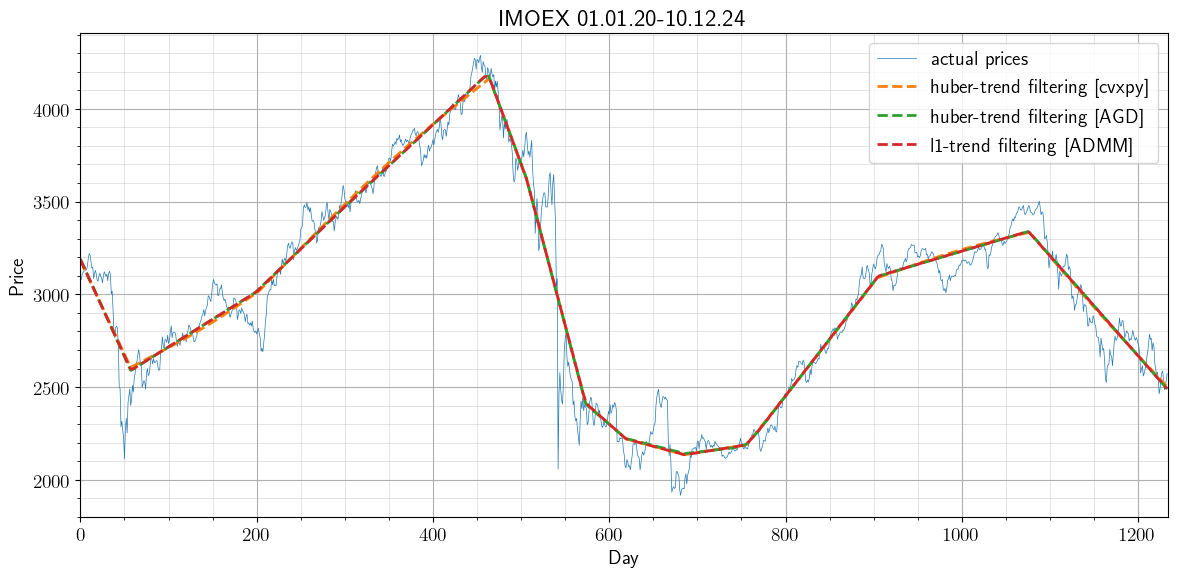

In [13]:
plot_price_and_trends(
    price=y,
    trends_dict={
        'huber-trend filtering [cvxpy]' : x_huber_cvxpy.value,
        'huber-trend filtering [AGD]' : x_agd,
        'l1-trend filtering [ADMM]' : x_admm
    }
)

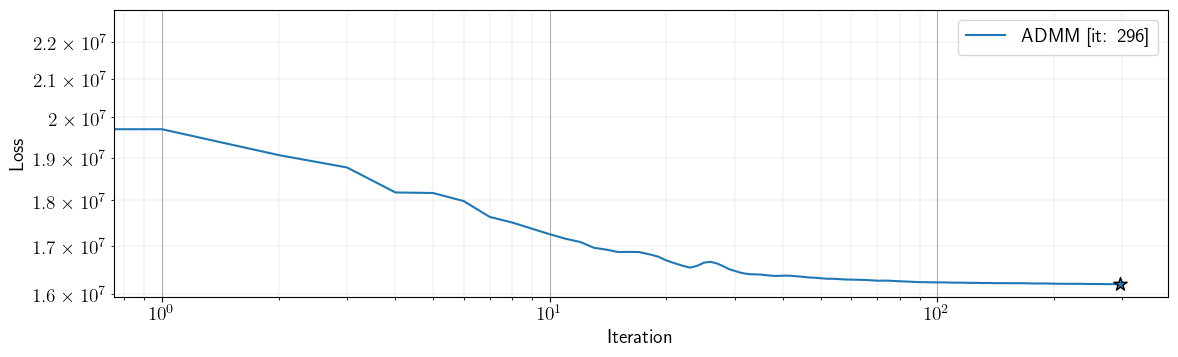

In [14]:
# gradient is plotted just for comparison with 
plot_grad_norm_and_loss(
    grad_norm_loss_dict={'ADMM' : (None, loss_log_admm)}
)

Полученные всеми рассмотренными методами решения сошлись примерно в одну точку, попарные значения RNMSE оказываются $(\Vert x - y\Vert / \Vert {y}\Vert)$ близки к нулю. Визуально также можно видеть, что все методы оптимизации выделили одинаковые тренды, которые действительно соотвествуют истории стоимости рассматриваемого фонда IMOEX. 

In [15]:
def nmse(x, ref):
    return np.linalg.norm(x - ref) / np.linalg.norm(ref)

In [16]:
print(f'RNMSE: x_agd  vs x_huber_cvxpy = {nmse(x_agd, x_huber_cvxpy.value):.5f}')
print(f'RNMSE: x_admm vs x_huber_cvxpy = {nmse(x_admm, x_huber_cvxpy.value):.5f}')
print(f'RNMSE: x_agd  vs x_admm        = {nmse(x_agd, x_admm):.5f}')

RNMSE: x_agd  vs x_huber_cvxpy = 0.00276
RNMSE: x_admm vs x_huber_cvxpy = 0.00258
RNMSE: x_agd  vs x_admm        = 0.00070


В рассматриваемой задаче метод ADMM показал лучшую скорость сходимости, обыгрывая по времени в ~20 раз ускоренный градиентный метод (AGD). Кроме того, в ходе подбора параметров метод ADMM покзал более устойчивое поведения при изменении начальной точки `x_0`. AGD, очевидно, оказался чувствительным к выбору начального шага `lr` и при изменении `x_0`, выбор оказался довольно кропотливым, часто метод не сходился в референсное решение `cvxpy` или вовсе расходился. В свою очередь ADMM сходился из разных `x_0`, получал решение, близкое к референсному, для достаточно широкого диапазона `rho`. 

В ADMM для данной задачи удалось найти аналитические решения подзадач, использовать предпосчет матриц и эффективные методы решения систем уравнений. ADMM является прямо-двойственным методом, что ускоряет сходимость. Кроме того, мы получили, что в данной задаче ADMM для обновления отделенной вспомогательной переменной $u$ в негладкой l1 норме использует проксимальный оператор, что значительно ускоряет теоретиеские оценки сходимости и что видно на практике. Данный подход оказался эффективнее "ручного" сглаживания регуляризационного слагаемого и решения через AGD.

С учетом использования разреженных матриц и специальных солверов для них, метод ADMM показал удивительную скорость сходимости, приближающуюся к низкоуровнево-оптимизированному солверу `OSQP` из `cvxpy`!

## ADMM (15 pts)

Рассмотрим задачу восстановления матрицы $Y$. Мы наблюдаем только небольшой набор элементов матрицы $Y$, множество индексов известных элементов обозначим через $E$. То есть мы знаем $Y_{ij}$ для всех $(i,j) \in E$, и не знаем $Y_{ij}$ для всех $(i,j) \notin E$.

Понятно, что без наличия какой-либо дополнительной информации о матрице $Y$ эта постановка является тривиальной: любая матрица $X$, для которой выполнено $X_{i,j} = Y_{i,j}, \quad (i,j) \in E$ является разумным ответом. Таких матриц бесконечно много. Соответственно задача восстановления матриц обычно рассматривается как частный случай задачи приближения матрицы, а критерий качества (целевая функция) говорит не столько о близости $X$ к $Y$, сколько о полезных свойствах матрицы $X$ (этим свойствам матрица $Y$ может и не обладать).

Одна из самых популярных постановок, с которой Вы наверняка сталкивались, например, строя рекомендательные системы, является задача о поиске наилучшего приближения заданной матрицы матрицей малого ранга:

$$
\begin{align*}
& \min_{X} rk(X) \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$

Как известно, в общем случае эта задача является NP-трудной. Для того, чтобы обойти это припятствие ранк матрицы аппроксимируется той или иной выпуклой функцией от матрицы $X$. Опять же стандартным выбором является переход к постановке задачи с использованием 1-й нормы Шаттена (она же trace norm).

$$
\begin{align*}
& \min_{X}\|X \|_* \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$

Здесь $X_* = \sum \sigma_i(X)$. 


1. (3 pts) Сведите задачу RegMC к виду, пригодному для решения методом ADMM
2. (5 pts) Выпишите аналитическую запись всех шагов вычисления метода ADMM для численного решения задачи, полученной в пункте 1.
3. (3 pts) Реализуйте метод ADMM наиболее вычислительно эффективным образом. 
4. (4 pts) Протестируйте реализованный метод ADMM на тестовых данных, например возьмите изображение и удалите из него часть пикселей. Как зависит точность восстановления от процента известных значений? 

Перепишем задачу в следующем эквивалентном виде:

$\begin{aligned}
&\min\limits_{x,z} \Vert X \Vert_*\\
&X = Z \\
&Z_{i,j} = Y_{i,j}, \; (i,j) \in E
\end{aligned}$

Модифицированная функция Лагранжа для данной задачи имеет вид:

$L_\rho(X, Z, \Lambda) = \Vert X \Vert_* + I_E(Z) + \Lambda^\top (X-Z) + \dfrac{\rho}{2}\Vert X - Z \Vert_F^2$, где $I_E(Z)$ &mdash; индикаторная функция:

$
I_E(Z) = \begin{cases}
0, & Z_{i,j} = Y_{i,j},\; (i,j)\in E,\\
+\infty, & \text{else}.
\end{cases}
$

Как и в предыдущем номере, выпишем сразу обновения переменных $X,Z,\Lambda$ в ходе одной итерации ADMM: 

**1. Обновление $X^k$:**

$\begin{aligned}
X^{k+1} &= \argmin\limits_X \Vert X \Vert_* + \langle\Lambda^k, X-Z^k\rangle + \dfrac{\rho}{2}\Vert X - Z^k \Vert_F^2 \\
&=  \argmin\limits_X \Vert X \Vert_* + \dfrac{\rho}{2}\Vert X - (Z^k - \Lambda^k/\rho) \Vert_F^2 \\
&= \text{prox}_{\frac{1}{\rho} \Vert \cdot \Vert_*} (Z^k - \Lambda^k/\rho) \\
&= \text{SVT}_{\frac{1}{\rho}} (Z^k - \Lambda^k/\rho)
\end{aligned}$

где $\text{SVT}_{\frac{1}{\rho}}(A)$ &mdash; soft-thresholding оператор для сингулярных чисел матрицы $A$, то есть: 

$A = U \Sigma V^\top,\; \Sigma_{i,i}' = \max(\Sigma_{i,i}-\frac{1}{\rho}, 0),\; \text{SVT}_{\frac{1}{\rho}}(A) = U \Sigma' V^\top$.

**2. Обновление $Z^k$:**

$\begin{aligned}
Z^{k+1} &= \argmin\limits_Z I_E(Z) + \langle\Lambda^k, X^{k+1}-Z\rangle + \dfrac{\rho}{2}\Vert X^{k+1} - Z \Vert_F^2 \\
&= \argmin\limits_Z I_E(Z) + \dfrac{\rho}{2}\Vert Z - (X^{k+1} + \Lambda^{k} /\rho) \Vert_F^2 \\
&= \argmin\limits_{Z\in E} \Vert Z - (X^{k+1} + \Lambda^{k} /\rho) \Vert_F^2 \\ \\
&= \pi_E(X^{k+1} + \Lambda^{k} /\rho)
\end{aligned}$

где $\pi_E(A)$ &mdash; проекция $A$ на значения $Y$ в индексах из $E$:

$
\pi_E(A) = \begin{cases}
Y_{i,j},\; (i,j)\in E,\\
A_{i,j},\; (i,j)\notin E.
\end{cases}
$

**3. Обновление $\Lambda^k$:**

$\Lambda^{k+1} = \Lambda^{k} + \rho (X^{k+1} - Z^{k+1})$.


**Источники:**

1. Условия останова по прямым и двойственным переменным и адаптивное изменение $\rho$ с некоторыми доработками (сравниваются не нормы невязок по прямым и двойственным, а относительные величины невязок к соответствующему порогу-условию останова) в ADMM вдохновлены следующим источником (глава 3):

    [[Boyd] Distributed Optimization and Statistical Learning via the Alternating Direction Method of Multipliers (2011)](https://web.stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf)

2. Подробный вывод проксимального оператора для ядерной нормы можно найти в документе (вывод был опущен для компактности изложения, можно заметить аналогию с проксимальным оператором для l1):

    [Лекции NYU](https://cims.nyu.edu/~cfgranda/pages/OBDA_spring16/material/low_rank_models.pdf)

In [17]:
import numpy as np
from sklearn.utils.extmath import randomized_svd

np.random.seed(0)

In [18]:
def svd_thresholding(M: np.ndarray, tau: float, max_rnd_rank: tp.Optional[float] = None) -> np.ndarray:
    if max_rnd_rank is None:
        U, S, Vt = np.linalg.svd(M, full_matrices=False)
    else:
        U, S, Vt = randomized_svd(M, max_rnd_rank, random_state=0)
    
    S_thresholded = np.maximum(S - tau, 0)  # Soft-thresholding
    return U @ np.diag(S_thresholded) @ Vt

def project_to_observed(X: np.ndarray, Y: np.ndarray, E_mask: np.ndarray) -> np.ndarray:
    X[E_mask] = Y[E_mask]  # in-place
    
    return X

def admm_matrix_completion(
        Y: np.ndarray, 
        E_mask: np.ndarray, 
        rho: float = 1.0, 
        max_iter: int = 100, 
        abstol: float = 1e-5, 
        reltol: float = 1e-4, 
        rho_upd_step: int = 10, 
        residual_eps_ratio_thres: float = 10., 
        rho_mul: float = 2., 
        max_rnd_rank: tp.Optional[float] = None,
        pbar_upd_step: int = 10
    ):
    m, n = Y.shape
    
    # initialize X
    X = np.zeros((m, n))
    X[E_mask] = Y[E_mask] 
    
    # initialize Z
    Z = np.zeros((m, n))
    Z[E_mask] = Y[E_mask] 
    
    # initialize dual variable
    Lambd = np.zeros((m, n))
    
    primal_residual = None
    dual_residual = None
    
    pbar = tqdm(range(max_iter))
    
    for it in pbar:
        # step 1: update X
        X = svd_thresholding(Z - Lambd / rho, 1 / rho, max_rnd_rank)
        
        # step 2: update Z using SVD thresholding
        Z_old = Z.copy()
        Z = project_to_observed(X + Lambd / rho, Y, E_mask)
        
        # step 3: update Lambd
        Lambd = Lambd + rho * (X - Z)
        
        # primal and dual residuals
        primal_residual = np.linalg.norm(X - Z)
        dual_residual = rho * np.linalg.norm(Z - Z_old)
        
        eps_primal = np.sqrt(n * m) * abstol + reltol * max(np.linalg.norm(Z), np.linalg.norm(X))
        eps_dual = np.sqrt(n * m) * abstol + reltol * rho * np.linalg.norm(Lambd)
        
        # if primal and dual residuals have different orders of magnitude compared to their thresholds,
        # try to change rho penalty with corresponding dual variable update
        # in order not to change rho too often, checks are performed each 10 iterations
        if it % rho_upd_step == 0:
            primal_re = primal_residual / eps_primal
            dual_re = dual_residual / eps_dual
            
            if primal_re > residual_eps_ratio_thres * dual_re:
                rho *= rho_mul
                Lambd /= rho_mul
            elif dual_re > residual_eps_ratio_thres * primal_re:
                rho /= rho_mul
                Lambd *= rho_mul

        # update progress bar info
        if it % pbar_upd_step == 0:
            pbar.set_postfix_str(
                f"{rho=:.3e}; {primal_residual=:.3e} [{eps_primal=:.3e}]; {dual_residual=:.3e} [{eps_dual=:.3e}]"
            )
        
        # Check convergence conditions
        if primal_residual < eps_primal and dual_residual < eps_dual:
            pbar.set_postfix_str(
                f"{rho=:.3e}; pr={primal_residual=:.3e} [{eps_primal=:.3e}]; {dual_residual=:.3e} [{eps_dual=:.3e}]"
            )
            break

    return X

Протестируем алгоритм на простых интерпретируемых примерах

№1 - здесь алгоритм верно достраивает матрицу до матрицы ранга 1 (наблюдения это допускают)

In [19]:
Y = np.array([
    [     1,      1, np.nan], 
    [     1, np.nan, np.nan], 
    [np.nan, np.nan, np.nan]]
)

E_mask = np.array([
    [True, True, False],
    [True, False, False],
    [False, False, False]
])

Y_observed = np.zeros_like(Y)
Y_observed[E_mask] = Y[E_mask]
    
Y_completed = admm_matrix_completion(
    Y_observed, 
    E_mask,
    abstol=1e-8,
    reltol=1e-7
)

print(f"\nCompleted matrix (rank={np.linalg.matrix_rank(Y_completed, tol=1e-4)}):\n{Y_completed}")

 24%|██▍       | 24/100 [00:00<00:00, 3358.91it/s, rho=1.000e+00; pr=primal_residual=1.324e-07 [eps_primal=2.300e-07]; dual_residual=1.405e-07 [eps_dual=1.714e-07]]


Completed matrix (rank=1):
[[1.00000013 1.         0.        ]
 [1.         0.99999985 0.        ]
 [0.         0.         0.        ]]


№2 - здесь алгоритм строит матрицу ранга 2, исходная матрица, очевидно, допускает ранга 1. Это связано с тем, что минимизация ядерной нормы лишь приближнно форсирует низкоранговость. Матрица с рангом 2 в данной задаче имеет сумму сингулярных чисел ниже, чем одноранговая (радует, что не получили ранг 3).

In [20]:
Y = np.array([
    [     1, np.nan,     42], 
    [np.nan, np.nan, np.nan], 
    [    42, np.nan, np.nan]]
)

E_mask = np.array([
    [True, False, True],
    [False, False, False],
    [True, False, False]
])

Y_observed = np.zeros_like(Y)
Y_observed[E_mask] = Y[E_mask]
    
Y_completed = admm_matrix_completion(Y_observed, E_mask)
print(f"Completed Matrix (rank={np.linalg.matrix_rank(Y_completed, tol=1e-4)}):\n{Y_completed}")

 57%|█████▋    | 57/100 [00:00<00:00, 7118.30it/s, rho=3.125e-02; pr=primal_residual=4.903e-04 [eps_primal=5.971e-03]; dual_residual=3.342e-05 [eps_dual=3.442e-05]]

Completed Matrix (rank=2):
[[ 1.00049027  0.         41.99999998]
 [ 0.          0.          0.        ]
 [41.99999998  0.          0.9976829 ]]


In [21]:
Y_rk1 = np.array([
    [     1,     0,     42], 
    [     0,     0,      0], 
    [    42,     0,  42**2]
])
np.linalg.matrix_rank(Y_rk1, tol=1e-4), np.linalg.eigvals(Y_rk1).sum()

(1, 1765.0)

In [22]:
Y_rk2 = np.array([
    [     1,     0,     42], 
    [     0,     0,      0], 
    [    42,     0,      1]
])
np.linalg.matrix_rank(Y_rk2, tol=1e-4), np.linalg.eigvals(Y_rk2).sum()

(2, 2.0)

№3 - тот же случай, что и в №2, наблюдения допускают очевидное построение матрицы ранга 1, но вновь матрица ранга 2 дает для данных наблюдений сумму сингулярных чисел меньше:

In [23]:
Y = np.array([
    [     1,      1,      1], 
    [     1, np.nan, np.nan], 
    [     1, np.nan, np.nan]
])

E_mask = np.array([
    [True, True, True],
    [True, False, False],
    [True, False, False]
])

Y_observed = np.zeros_like(Y)
Y_observed[E_mask] = Y[E_mask]
    
Y_completed = admm_matrix_completion(Y_observed, E_mask)
print(f"Completed Matrix (rank={np.linalg.matrix_rank(Y_completed)}):\n{Y_completed}")

 22%|██▏       | 22/100 [00:00<00:00, 5928.73it/s, rho=1.000e+00; pr=primal_residual=5.344e-05 [eps_primal=2.749e-04]; dual_residual=1.290e-04 [eps_dual=1.714e-04]]

Completed Matrix (rank=2):
[[1.00005344 0.99999999 0.99999999]
 [0.99999999 0.49984426 0.49984426]
 [0.99999999 0.49984426 0.49984426]]


In [24]:
Y_rk1 = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])
np.linalg.matrix_rank(Y_rk1, tol=1e-4), np.linalg.eigvals(Y_rk1).sum()

(1, 3.0)

In [25]:
Y_rk2 = np.array([
    [1, 1, 1],
    [1, 0.5, 0.5],
    [1, 0.5, 0.5]
])
np.linalg.matrix_rank(Y_rk2, tol=1e-4), np.linalg.eigvals(Y_rk2).sum()

(2, 1.9999999999999996)

Теперь проведем эксперименты с картинкой. Будем случайным образом выбирать на картинке пиксели, которые останутся наблюдаемыми
(iid бернулиевская величина с параметром $p = p_\text{observed}$). Таким образом, лишь $\approx p_\text{observed}$ доля пикселей попадут в множество $E$.  

In [26]:
def reg_mc_experiment(Y_full_photo, p_observed_series):    
    n, m = Y_full_photo.shape
    
    num_rows = len(p_observed_series)
    
    fig, ax = plt.subplots(num_rows, 4, figsize=(15, 4 * num_rows))
    ax = ax.flatten()
    
    for row, p_observed_curr in enumerate(p_observed_series):
        
        E_photo_mask = np.random.choice([True, False], size=(n, m), p=[p_observed_curr, 1-p_observed_curr])

        Y_photo_observed = np.zeros_like(Y_full_photo)
        Y_photo_hidden = np.zeros_like(Y_full_photo)

        Y_photo_observed[E_photo_mask] = Y_full_photo[E_photo_mask]
        Y_photo_hidden[~E_photo_mask] = Y_full_photo[~E_photo_mask]
        
        Y_photo_completed = admm_matrix_completion(
            Y_photo_observed, 
            E_photo_mask, 
            max_iter=3000,
            rho=1.,
            abstol=1e-5,
            reltol=1e-5,
            rho_upd_step=10,
            max_rnd_rank=None
        )
        
        ax[4*row + 0].set_title(f'Observation mask [p={p_observed_curr}]')
        ax[4*row + 0].imshow(E_photo_mask, cmap='gray')
        ax[4*row + 0].axis('off')
        
        ax[4*row + 1].set_title('Original image')
        ax[4*row + 1].imshow(Y_full_photo, cmap='gray')
        ax[4*row + 1].axis('off')

        ax[4*row + 2].set_title('Observed image')
        ax[4*row + 2].imshow(Y_photo_observed, cmap='gray')
        ax[4*row + 2].axis('off')
        
        ax[4*row + 3].set_title('Completed image')
        ax[4*row + 3].imshow(Y_photo_completed, cmap='gray')
        ax[4*row + 3].axis('off')
        
    fig.tight_layout()

forest.jpg: 256 x 256


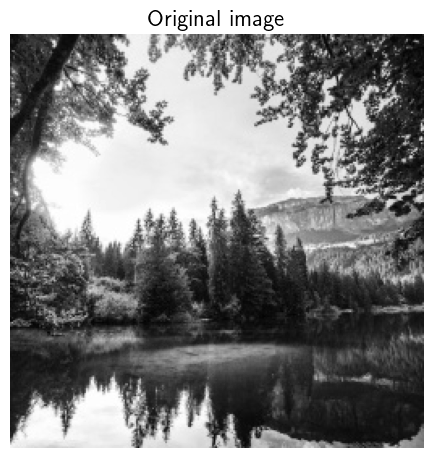

In [27]:
image_filename = 'forest.jpg'
Y_full_photo = plt.imread(image_filename).mean(axis=-1)  # make the photo b&w

n, m = Y_full_photo.shape

print(f'{image_filename}: {n} x {m}')

fig, ax = plt.subplots()

ax.set_title('Original image')
ax.imshow(Y_full_photo, cmap='gray')
ax.axis('off')
fig.tight_layout()

100%|██████████| 3000/3000 [02:12<00:00, 22.65it/s, rho=3.906e-03; primal_residual=4.671e-02 [eps_primal=8.503e-02]; dual_residual=3.918e-03 [eps_dual=2.560e-03]]


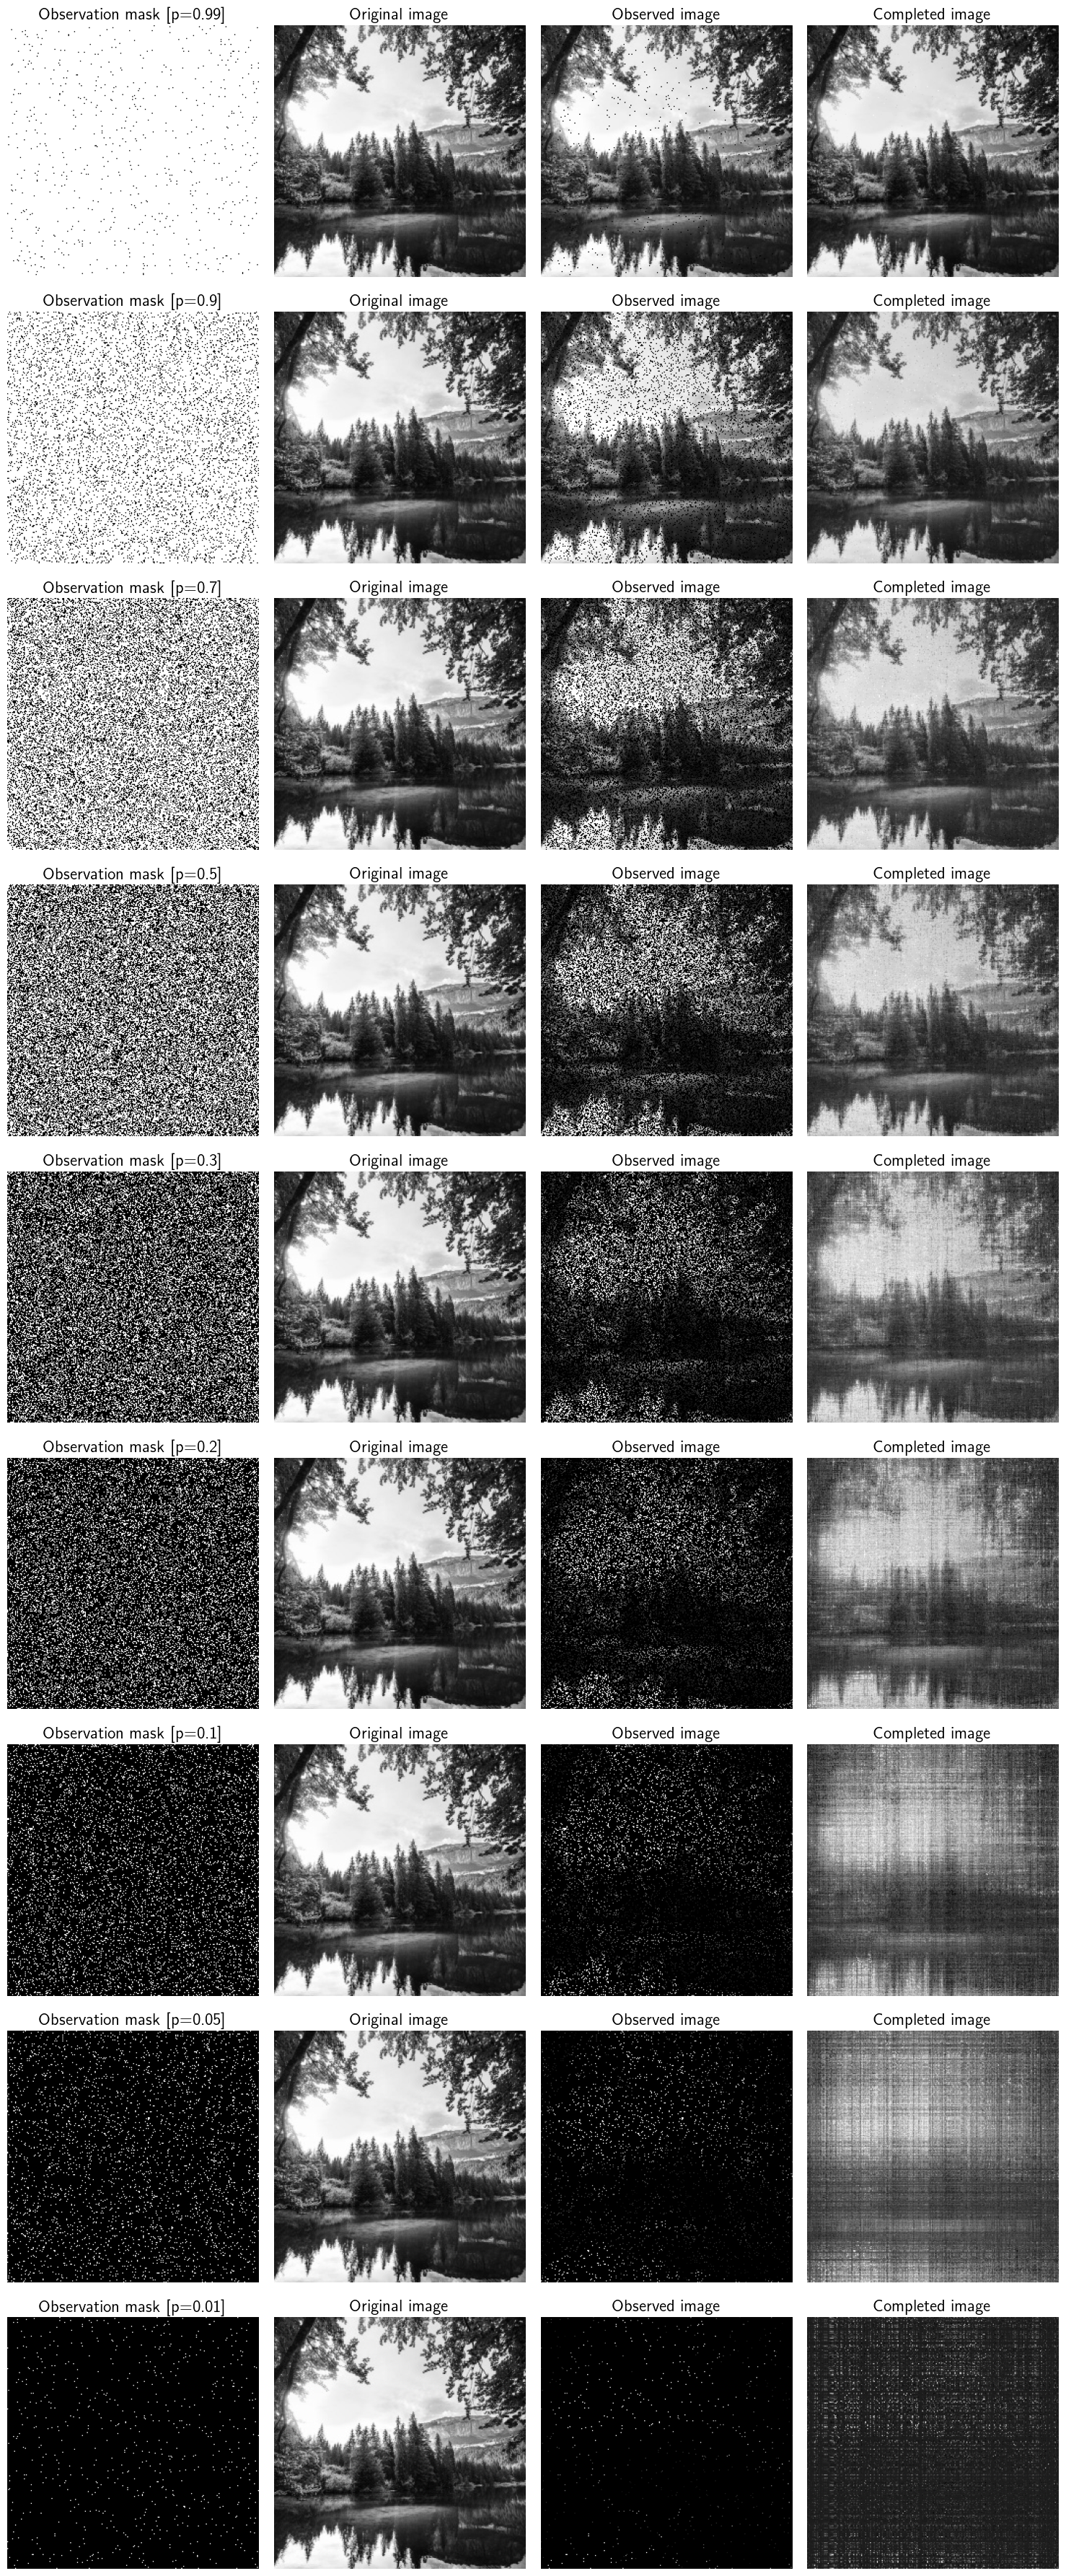

In [28]:
# lauch experiments for different p_observed parameters
p_observed_series = [0.99, 0.9, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]

reg_mc_experiment(Y_full_photo, p_observed_series)

Можем видеть, что фотография довольно хорошо восстанавливается для случая большого числа наблюдений $E$. При снижении числа наблюдений качество стагнирует, но даже на довольно низких уровнях $p$ можно разглядеть очертания изображения, что едва ли можно сделать напрямую из наблюдений. Скорость сходимости практически монотонно растет при уменьшении $p$, при малом числе наблюдений число итераций и время работы становится уже значительными, в последнем случае наблюдается остановка по числу итераций (но с близкими к порогу значениями невязок).

### Один из способов ускорения алгоритма - randomized SVD

Предлагается следующий метод ускорения алгоримта для случаев, когда исходная матрица $Y$ имеет низкий ранг и/или в случае крайне разреженных/низкоранговых наблюдений $E$. Вместо полного SVD будем считать рандомизированный вариант алгоритма, в котором находится $r$ наибольших сингулярных чисел и соответствующих им сингулярных векторов. Имея информацию о низком ранге исходных данных или разреженности измерений, можно сильно ограничить $r$, то есть ограничить ранг получаемой оценки $X$, но увеличить скорость отдельной итерации и общую скорость сходимости (можно ожидать ускорения порядка $\min(n, m)/r$, где $n, n$ &mdash; размерности картинки). 

Для примера возьмем изобажение с явно низкоранговой структурой (вертикальные линии с небольшими мелкими деталями и некоторой текстурой), дополнительно рассмотрим крайне разреженные измерения ($p=0.05$).

In [29]:
image_filename = 'lines.jpg'
Y_full_photo = plt.imread(image_filename).mean(axis=-1)  # make the photo b&w

n, m = Y_full_photo.shape

print(f'{image_filename}: {n} x {m}')

lines.jpg: 512 x 512


In [30]:
p_observed = 0.05

E_photo_mask = np.random.choice([True, False], size=(n, m), p=[p_observed, 1-p_observed])

Y_photo_observed = np.zeros_like(Y_full_photo)
Y_photo_hidden = np.zeros_like(Y_full_photo)

Y_photo_observed[E_photo_mask] = Y_full_photo[E_photo_mask]
Y_photo_hidden[~E_photo_mask] = Y_full_photo[~E_photo_mask]

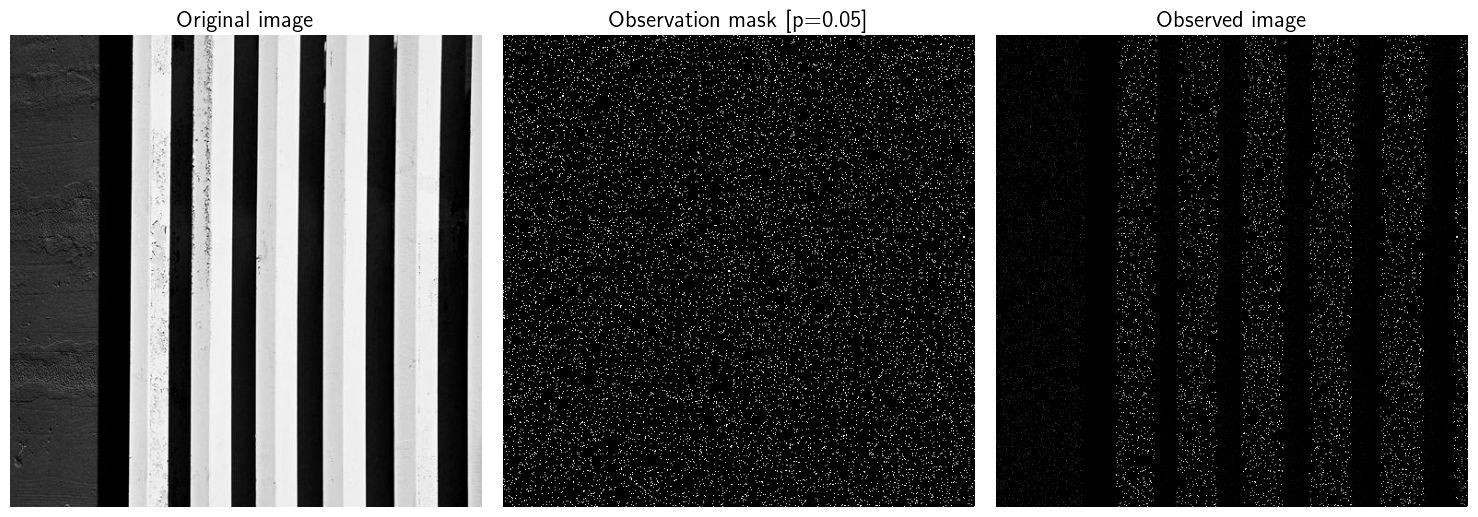

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))

ax[0].set_title('Original image')
ax[0].imshow(Y_full_photo, cmap='gray')
ax[0].axis('off')
#ax.set_title(k, size=15)

ax[1].set_title(f'Observation mask [p={p_observed}]')
ax[1].imshow(E_photo_mask, cmap='gray')
ax[1].axis('off')
#ax.set_title(k, size=15)

ax[2].set_title('Observed image')
ax[2].imshow(Y_photo_observed, cmap='gray')
ax[2].axis('off')
#ax.set_title(k, size=15)
fig.tight_layout()

In [32]:
Y_photo_completed_dense = admm_matrix_completion(
    Y_photo_observed, 
    E_photo_mask, 
    max_iter=2000, 
    rho=1e-4,
    abstol=1e-5,
    reltol=1e-3,
    rho_upd_step=10,
    max_rnd_rank=None
)

 12%|█▏        | 231/2000 [00:44<05:41,  5.18it/s, rho=2.000e-04; pr=primal_residual=7.691e+01 [eps_primal=7.732e+01]; dual_residual=2.035e-03 [eps_dual=5.123e-03]]


In [33]:
# max_rnd_rank - number of biggest singular values to compute using randomized svd
Y_photo_completed_sparse = admm_matrix_completion(
    Y_photo_observed, 
    E_photo_mask, 
    max_iter=2000, 
    rho=1e-4,
    abstol=1e-5,
    reltol=1e-3,  # relaxed tolerance
    rho_upd_step=10,
    max_rnd_rank=120  # max rank
)

 12%|█▏        | 231/2000 [00:27<03:30,  8.40it/s, rho=2.000e-04; pr=primal_residual=7.731e+01 [eps_primal=7.733e+01]; dual_residual=2.120e-03 [eps_dual=5.123e-03]]


Можем видеть, что **randomized SVD** с ограничением на ранг имеет скорость сходимости в несколько раз выше (в последнем запуске оказался чуть медленнее, не самая лучшая реализация из sklearn), при этом качество восстановления картинки (при описанных выше условиях на $Y$ и $E$) оказывается таким же:

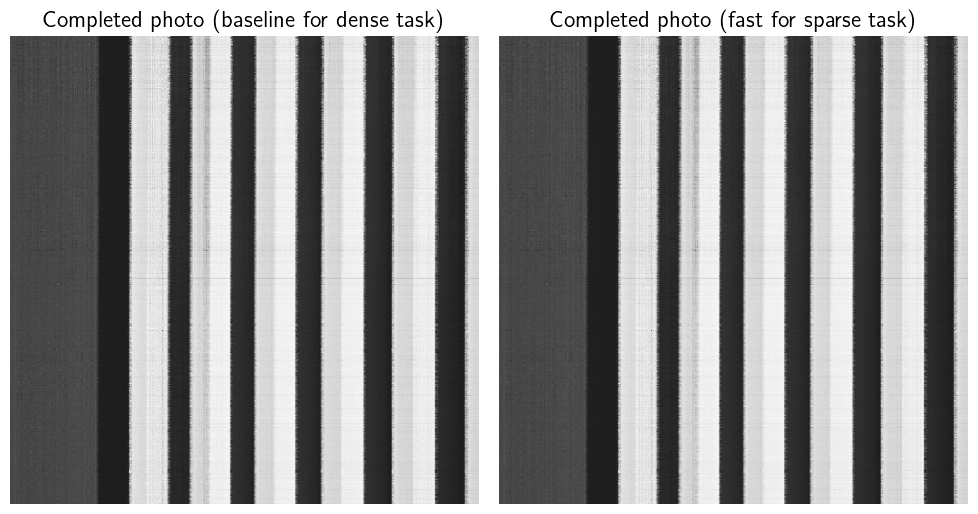

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].set_title('Completed photo (baseline for dense task)')
ax[0].imshow(Y_photo_completed_dense, cmap='gray')
ax[0].axis('off')

ax[1].set_title('Completed photo (fast for sparse task)')
ax[1].imshow(Y_photo_completed_sparse, cmap='gray')
ax[1].axis('off')
#ax.set_title(k, size=15)
fig.tight_layout()